In [1]:
hiapp = ['2021-03-03_IAPP_2n5_sliceA_0V_dt_extracted.txt', '2021-03-03_IAPP_2n5_sliceA_10V_dt_extracted.txt', '2021-03-03_IAPP_2n5_sliceA_20V_dt_extracted.txt', '2021-03-03_IAPP_2n5_sliceA_30V_dt_extracted.txt', '2021-03-03_IAPP_2n5_sliceA_40V_dt_extracted.txt', '2021-03-03_IAPP_2n5_sliceA_50V_dt_extracted.txt', '2021-03-03_IAPP_2n5_sliceA_60V_dt_extracted.txt', '2021-03-03_IAPP_2n5_sliceA_70V_dt_extracted.txt']

AllData = [] 

for filename in hiapp:
    filenameparts = filename.split('_')
    voltage = filenameparts[4].replace('V', '')
    voltage = int(voltage)
    with open (filename, 'r') as f:
        for dataline in f:
            dataline = dataline.replace('\n', '')
            arrtime_intensity = dataline.split('\t')
            arrtime = (float(arrtime_intensity[0]))
            #ArrTimes.append(arrtime)
            intensity = (int(arrtime_intensity[1]))
            #Intensities.append(intensity)
            #alldata = (voltage + np.random.uniform(-1,1), arrtime, intensity)
            alldata = (voltage, arrtime, intensity)
            AllData.append(alldata)

#print(Coords)
NonZeroData = [c for c in AllData if c[2] != 0]
ArrTimes = [c[1] for c in AllData if c[2] != 0]
Intensities = [c[2] for c in AllData if c[2] != 0]
Voltages = [c[0] for c in AllData if c[2] != 0]
Coord_tuples = [(c[1],c[0]) for c in AllData if c[2] != 0]

all_voltages = [x[0] for x in AllData]
all_arrtimes = [x[1] for x in AllData if x[1]<85]


import numpy as np
Int_arr = np.asarray(Intensities)
Volt_arr = np.asarray(Voltages)
ArrT_arr = np.asarray(ArrTimes)
Coord_arr = np.column_stack((ArrT_arr, Volt_arr))
Coord_tup_arr = np.asarray(Coord_tuples)

voltage_set = sorted(set(all_voltages))
arrtime_set = sorted(set(all_arrtimes))
print(arrtime_set)
vidx = {v:i for i,v in enumerate(voltage_set)}
aidx = {a:i for i,a in enumerate(arrtime_set)}
input_density = np.zeros((len(voltage_set), len(arrtime_set)))
for v, a, intens in AllData:
    if a>85:
        continue
    j = vidx[v]
    k = aidx[a]
    input_density[j,k] = intens

print(input_density)


[54.982, 55.228, 55.474, 55.72, 55.966, 56.212, 56.458, 56.704, 56.95, 57.196, 57.442, 57.688, 57.934, 58.18, 58.426, 58.672, 58.918, 59.164, 59.41, 59.656, 59.902, 60.148, 60.394, 60.64, 60.886, 61.132, 61.378, 61.624, 61.87, 62.116, 62.362, 62.608, 62.854, 63.1, 63.346, 63.592, 63.838, 64.084, 64.33, 64.576, 64.822, 65.068, 65.314, 65.56, 65.806, 66.052, 66.298, 66.544, 66.79, 67.036, 67.282, 67.528, 67.774, 68.02, 68.266, 68.512, 68.758, 69.004, 69.25, 69.496, 69.742, 69.988, 70.234, 70.48, 70.726, 70.972, 71.218, 71.464, 71.71, 71.956, 72.202, 72.448, 72.694, 72.94, 73.186, 73.432, 73.678, 73.924, 74.17, 74.416, 74.662, 74.908, 75.154, 75.4, 75.646, 75.892, 76.138, 76.384, 76.63, 76.876, 77.122, 77.368, 77.614, 77.86, 78.106, 78.352, 78.598, 78.844, 79.09, 79.336, 79.582, 79.828, 80.074, 80.32, 80.566, 80.812, 81.058, 81.304, 81.55, 81.796, 82.042, 82.288, 82.534, 82.78, 83.026, 83.272, 83.518, 83.764, 84.01, 84.256, 84.502, 84.748, 84.994]
[[0.00000e+00 0.00000e+00 0.00000e+00 0.0

In [2]:
#import matplotlib.pyplot as plt
#from sklearn.mixture import GaussianMixture as GM
import pomegranate
print(pomegranate.GeneralMixtureModel)

<class 'pomegranate.gmm.GeneralMixtureModel'>


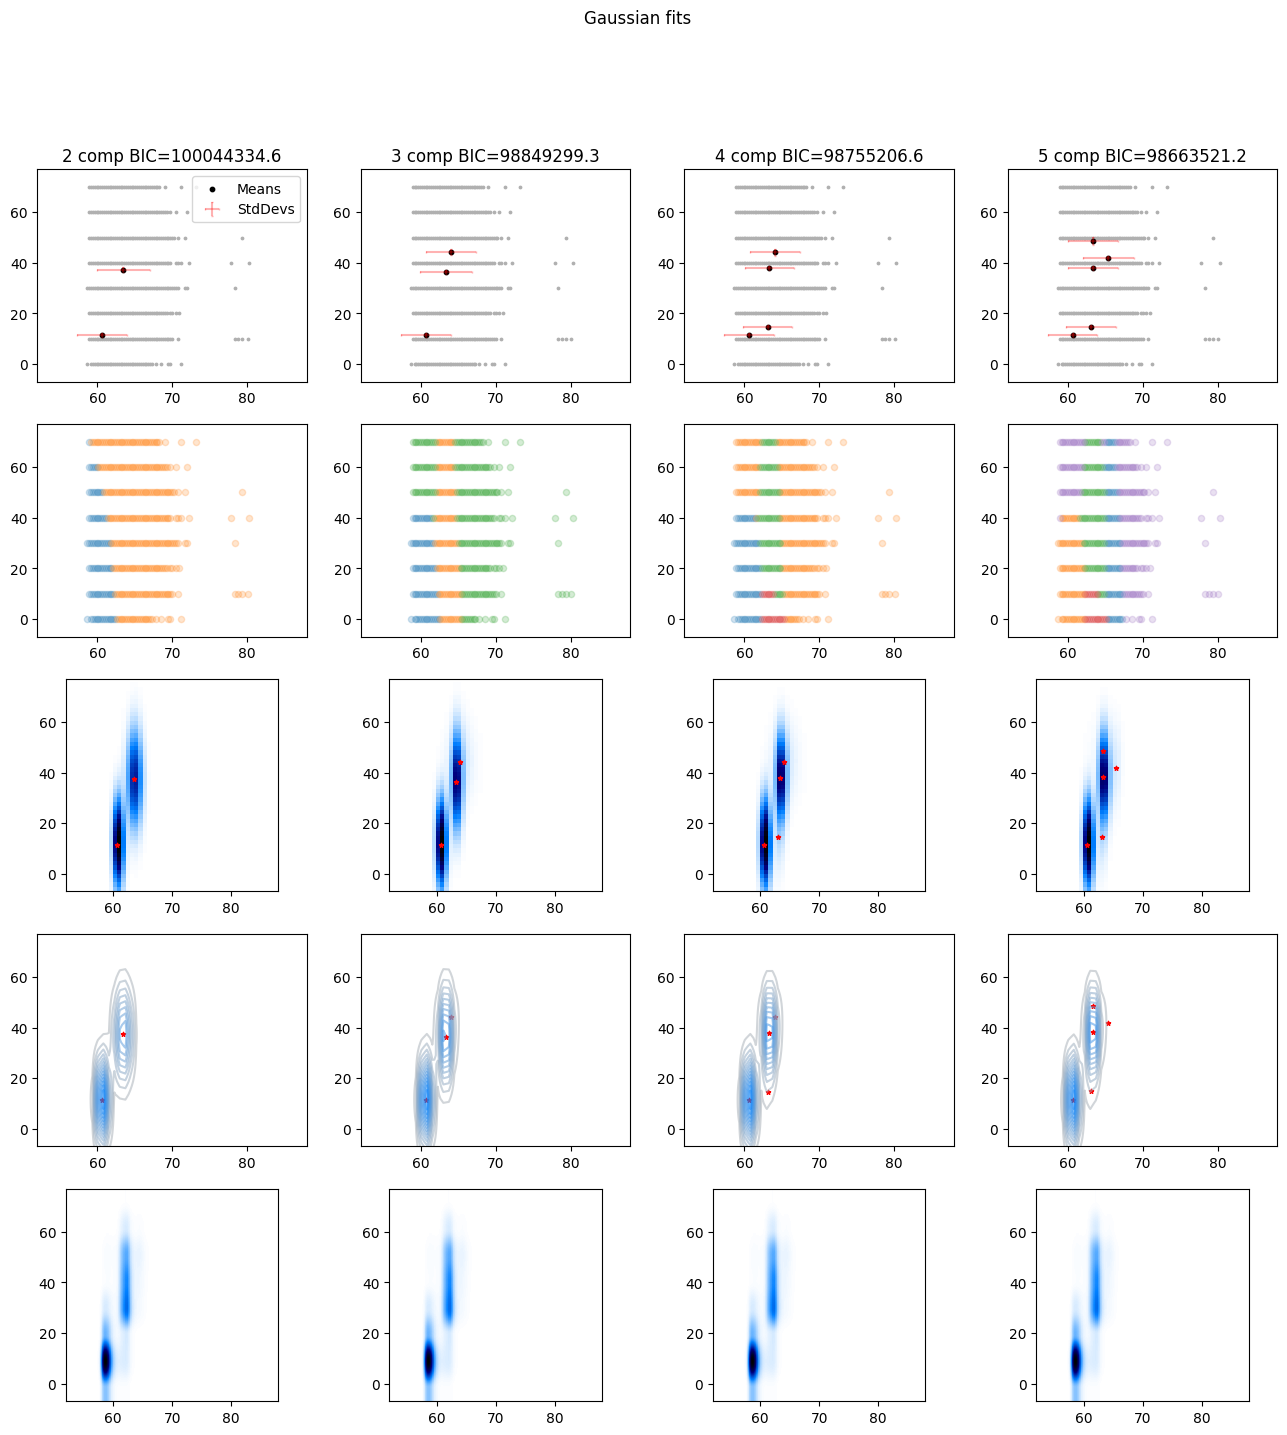

In [3]:
from pomegranate import GeneralMixtureModel, MultivariateGaussianDistribution, IndependentComponentsDistribution, NormalDistribution

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

#from sklearn.mixture import GaussianMixture
#from pomegranate import GeneralMixtureModel, MultivariateGaussianDistribution, IndependentComponentsDistribution, NormalDistribution

n_contours = 16
density_colormap = LinearSegmentedColormap.from_list(name='density', colors=['#FFFFFF','#0080FF','#000080','#000000'], N=256)
contour_colormap = LinearSegmentedColormap.from_list(name='contour', colors=['#B0B0B0','#0080FF'], N=n_contours)

xgap = (max(all_arrtimes) - min(all_arrtimes))/10
ygap = (max(all_voltages) - min(all_voltages))/10
x_range = (min(all_arrtimes)-xgap, max(all_arrtimes)+xgap) #set on min plus a bit and vv for volatges and arrtimes. 
y_range = (min(all_voltages)-ygap, max(all_voltages)+ygap)

#x_range = (min(all_arrtimes)-xgap, 70.0)

test_n_components = [2,3,4,5]

fig1, axarr = plt.subplots(5, len(test_n_components))
fig1.suptitle('Gaussian fits')
fig1.set_size_inches(16,16)

best_bic = float('inf')
best_gmm = None

class MinStdNormalDistributionX(NormalDistribution):
    def __init__(self, *args, **kw):
        kw['min_std'] = 0.6
        NormalDistribution.__init__(self, *args, **kw)
class MinStdNormalDistributionY(NormalDistribution):
    def __init__(self, *args, **kw):
        kw['min_std'] = 11
        NormalDistribution.__init__(self, *args, **kw)

for i, n_comp in enumerate(test_n_components):
    ax1 = axarr[0,i] # First fig row
    ax1.set_xlim(x_range)
    ax1.set_ylim(y_range)
  
  # Like covariance_type='full'
    #gmm = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution,
                                        # n_comp, grid_data, hist_weights, n_init=1) 
   ##Like covariance_type='diag'
    gmm = GeneralMixtureModel.from_samples([MinStdNormalDistributionX, MinStdNormalDistributionY],
                                         n_comp, Coord_tup_arr, Int_arr, n_init = 5, max_kmeans_iterations = 30) 
  
  # Degrees of freedom per Gaussian component: 2 (cov xx, yy[as diag]) + 2 (mean x, y) + 1 (weight)
  # all -1 due to sum weights == 1.0
    df = (5 * n_comp) - 1
    lp = (gmm.log_probability(Coord_tup_arr) * Int_arr).sum() #sum, as in log space, normally porbs would multiply. 
    bic = float(df * np.log(len(Coord_tup_arr)) - 2.0 * lp) # For evaluating best n_comp
  
  # For multivarate
    #x_vals_mean = [comp.parameters[0][0] for comp in gmm.distributions]
    #y_vals_mean = [comp.parameters[0][1] for comp in gmm.distributions]
    #covars = np.array([comp.parameters[1] for comp in gmm.distributions])
    #x_vals_std = np.sqrt(covars[:,0,0]) # x to x variance from covar mat
    #y_vals_std = np.sqrt(covars[:,1,1]) # y to y variance from covar mat
  
  # For independent x,y normals
    comp_params = [comp.parameters[0] for comp in gmm.distributions] # Selects IndependentComponentsDistribution for each Gaussian
    x_params = [cp[0].parameters for cp in comp_params] # NormalDistribution for X : Mean, Var pairs
    y_params = [cp[1].parameters for cp in comp_params] # NormalDistribution for Y : Mean, Var pairs
  
    x_vals_mean, x_vals_var = zip(*x_params) 
    y_vals_mean, y_vals_var = zip(*y_params) 
    
  # Sqrt for Var to Std
    x_vals_std = np.sqrt(x_vals_var)
    y_vals_std = np.sqrt(y_vals_var)
  
    ax1.scatter(ArrT_arr, Volt_arr, s=3, alpha=1.0, c='#B0B0B0')
    #plot voltages and arrtimes instead. alpha redundant. do changing sizes mayeb where more intense. s = array or list based on int. 
    ax1.errorbar(x_vals_mean, y_vals_mean, x_vals_std, y_vals_std, fmt='none',
               color='red',alpha=0.3,  label='StdDevs', capsize=0.5)
  
    ax1.scatter(x_vals_mean, y_vals_mean, s=10, c='black', marker='o', label='Means')
  
    ax1.set_title(f'{n_comp} comp BIC={bic:.1f}')
  
    if i == 0:
        ax1.legend()
  
  # Component predition of _original_ points 

    ax2 = axarr[1,i] # Second fig row
    ax2.set_xlim(x_range)
    ax2.set_ylim(y_range)

    labels = gmm.predict(Coord_tup_arr) #or (Volt_arr, ArrT_arr)

    for j in range(n_comp):
        selection = labels == j # Bool array
        ax2.scatter(ArrT_arr[selection], Volt_arr[selection], s=20, alpha=0.2)
  
  # Density estimation of a grid of points
    n_grid = 50
    x_points = np.linspace(x_range[0], x_range[1], n_grid) # sampling whole mesh for evaluation 
    y_points = np.linspace(y_range[0], y_range[1], n_grid)
    
    x_grid, y_grid = np.meshgrid(x_points, y_points) # n_grid , n_grid of coordinates
    x_grid_flat = x_grid.ravel()  # Flatten to list
    y_grid_flat = y_grid.ravel() 
    stacked_points = np.stack([x_grid_flat, y_grid_flat], axis=1) # to get x,y pairs
  
  
    density = gmm.log_probability(stacked_points) # comes as log probabilties
    density = np.exp(density) # Real probs
    density_2d = density.reshape([n_grid, n_grid]) # Restore points grid (of heights)
    
    ax3 = axarr[2,i] # third fig row
    ax3.set_xlim(x_range)
    ax3.set_ylim(y_range)
    aspect = (x_range[1] - x_range[0])/(y_range[1] - y_range[0])
    ax3.imshow(density_2d, cmap=density_colormap, origin='lower', extent=x_range + y_range, aspect=aspect) 
    ax3.scatter(x_vals_mean, y_vals_mean, s=10, c='red', marker='*', label='Means')

  
    ax4 = axarr[3,i]
    ax4.contour(x_grid, y_grid, density_2d, levels=n_contours, alpha=0.5, cmap=contour_colormap)
    ax4.scatter(x_vals_mean, y_vals_mean, s=10, c='red', marker='*', label='Means')

    ax5 = axarr[4,i]
    ax5.imshow(input_density, cmap=density_colormap, origin='lower', extent=x_range + y_range, aspect=aspect) 
  # Equalise scale to input
    #density_2d *= input_density.sum()/density_2d.sum()
  
    #diff = input_density - density_2d
    #maxd = 40 # Set by inspection; same scale for all plots
    #rms = np.sqrt(np.mean(diff*diff))

    #ax5.set_title(f'Residual RMS = {rms:.3}')
    #ax5.set_xlim(x_range)
    #ax5.set_ylim(y_range)
    #ax5.imshow(diff, cmap='coolwarm', vmin=-maxd, vmax=maxd, origin='lower', extent=x_range + y_range)


plt.show()
